In [1]:
# import
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
import random
import torch.nn as nn
import torch.nn.functional as F
import warnings
import datetime
from copy import deepcopy
from diffusion_crt import *

def transform(x):
    return torch.log(x)-torch.log(1-x)

def re_transform(x):
    return 1/(1+torch.exp(-x))

def inverse_to_original(z, x_min, x_max):
    # Step 1: inverse logit
    u = 1 / (1 + torch.exp(-z))

    # Step 2: undo division by 1.02
    x_norm = u * 1.02

    # Step 3: undo +0.01 shift
    x_scaled = x_norm - 0.01

    # Step 4: undo min-max normalization
    x_original = x_scaled * (x_max - x_min) + x_min

    return x_original

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(999)

In [3]:
#data gen and plot
sns.set()
plt.rcParams['figure.figsize'] = (24, 18)        
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['legend.title_fontsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['font.size'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
dz=5
num = 500 

device = torch.device('cuda')
dataset_x=torch.randn((num,dz))
dataset_y=dataset_x[:,0:1]**2+torch.exp(dataset_x[:,1:2]+
                                        dataset_x[:,2:3]/3)+dataset_x[:,3:4]-dataset_x[:,4:5]+(0.5+dataset_x[:,1:2]**2/2+dataset_x[:,4:5]**2/2)*torch.randn((num,1))


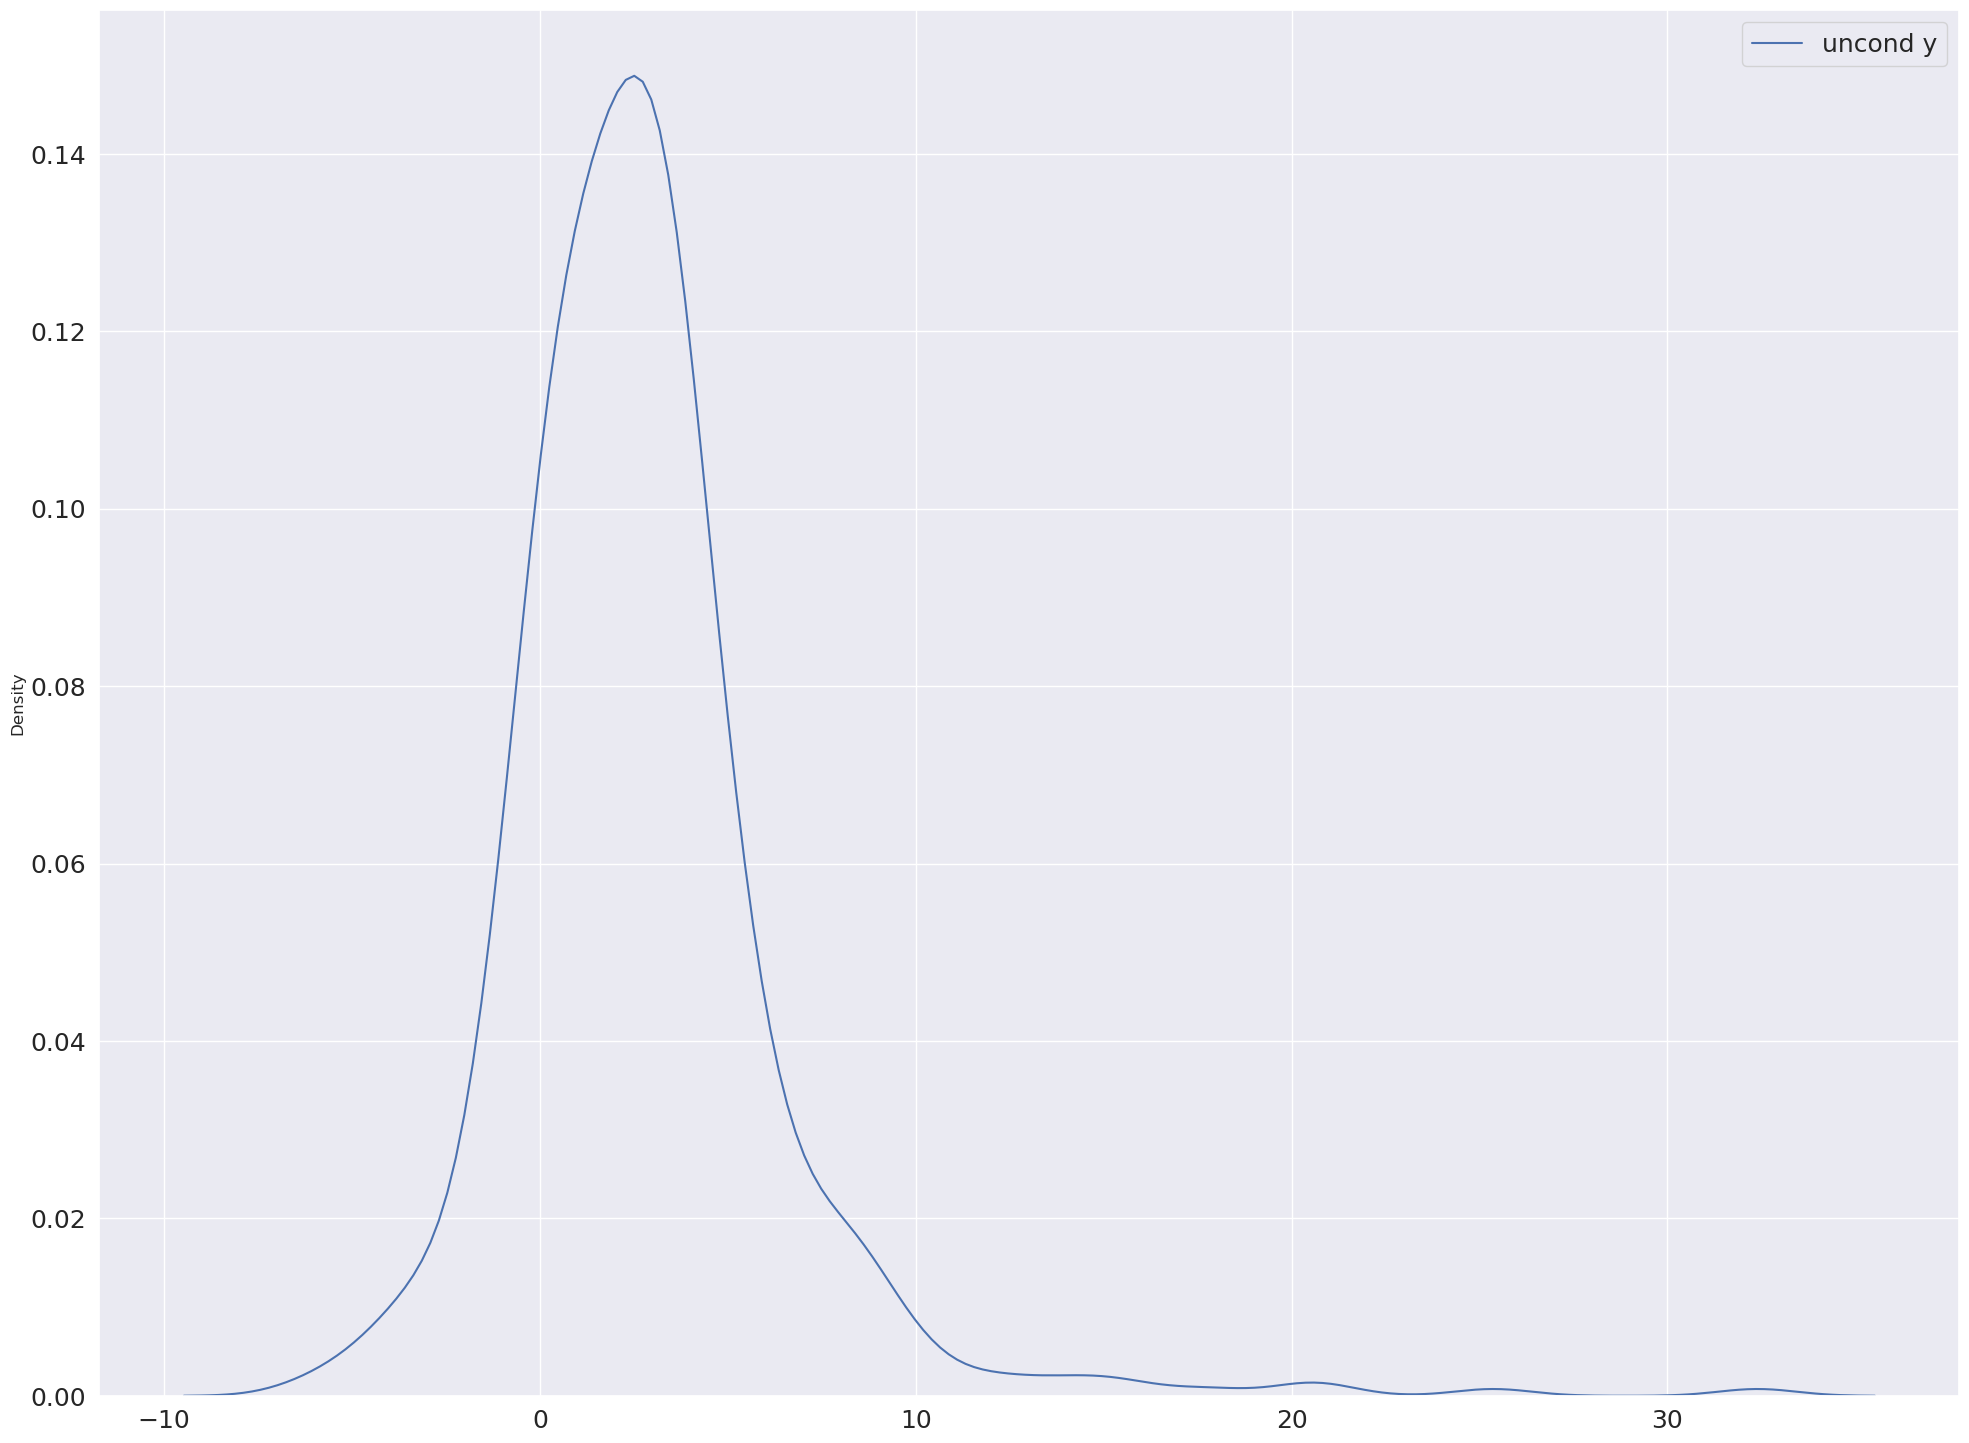

In [4]:
sns.kdeplot(dataset_y.view(-1), label = 'uncond y')
plt.legend()

In [5]:


dataset_x=dataset_x.to(device)
dataset_y=dataset_y.to(device)

x_min, x_max = dataset_x.min(), dataset_x.max()
y_min, y_max = dataset_y.min(), dataset_y.max()




In [6]:
x_normalized = (dataset_x - x_min) / (x_max - x_min) +0.01
y_normalized = (dataset_y - y_min) / (y_max - y_min) +0.01

In [7]:
x_normalized_transformed = transform(x_normalized/1.02).float().to(device)
y_normalized_transformed = transform(y_normalized/1.02).float().to(device)

In [8]:
num_steps = 1000
betas=make_beta_schedule(schedule="linear", num_timesteps=num_steps,start=1e-4, end=2e-2)
alphas=1-betas
alphas_bar=torch.cumprod(alphas,0).to(device)
alphas_bar_sqrt=torch.sqrt(alphas_bar)
one_minus_alphas_bar_sqrt=torch.sqrt(1-alphas_bar)

In [9]:
val_index = 450
dataloader = torch.utils.data.DataLoader(torch.cat([x_normalized_transformed[:val_index,:], y_normalized_transformed[:val_index,:]], dim=1), 
                                         batch_size=9999,shuffle=True, )

x_val = x_normalized_transformed[val_index:,:]
y_val = y_normalized_transformed[val_index:,:]

In [10]:
model = DiffusionModelWithEmbedding(input_dim=dataset_y.shape[1], 
                                time_steps=num_steps, embedding_dim=32,
                                cond_dim=dz,hidden_dim=16).to(device)

In [11]:
import copy

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
num_epoch = 2000

ema2 = EMA(model)

best_val_loss = float("inf")

# ✅ 用来存最优模型参数（在内存里）
best_model_state = None
best_ema_state = None


for epoch in range(num_epoch):

    # ============================
    # Training
    # ============================
    model.train()
    total_train_loss = 0

    for idx, batch in enumerate(dataloader):

        batch_x = batch[:, :dz].to(device)
        batch_y = batch[:, dz:].to(device)

        loss = diffusion_loss_fn(
            model,
            batch_y,
            batch_x,
            alphas_bar_sqrt,
            one_minus_alphas_bar_sqrt,
            num_steps,
            device
        )

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()

        # EMA update
        ema2.update(model)

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(dataloader)

    # ============================
    # Validation
    # ============================
    model.eval()
    with torch.no_grad():

        val_loss = diffusion_loss_fn(
            model,
            y_val.to(device),
            x_val.to(device),
            alphas_bar_sqrt,
            one_minus_alphas_bar_sqrt,
            num_steps,
            device
        )

    val_loss_value = val_loss.item()

    # ============================
    # Keep best model in memory
    # ============================
    if val_loss_value < best_val_loss:

        best_val_loss = val_loss_value

        # ✅ 深拷贝参数（存在 RAM 里）
        best_model_state = copy.deepcopy(model.state_dict())
        best_ema_state = copy.deepcopy(ema2.state_dict())

        print(f"✅ Best model updated at epoch {epoch}, val_loss={best_val_loss:.6f}")

    # ============================
    # Logging
    # ============================
    print(f"Epoch [{epoch}/{num_epoch}] "
          f"Train Loss: {avg_train_loss:.6f} "
          f"Val Loss: {val_loss_value:.6f}")


model.load_state_dict(best_model_state)
ema2.load_state_dict(best_ema_state)

print("🎉 Training finished!")
print("✅ Best model restored from memory")
print("Best Val Loss =", best_val_loss)

✅ Best model updated at epoch 0, val_loss=1.072198
Epoch [0/2000] Train Loss: 1.076398 Val Loss: 1.072198
✅ Best model updated at epoch 1, val_loss=0.783457
Epoch [1/2000] Train Loss: 0.987534 Val Loss: 0.783457
Epoch [2/2000] Train Loss: 0.911215 Val Loss: 1.108830
Epoch [3/2000] Train Loss: 0.981413 Val Loss: 1.255093
Epoch [4/2000] Train Loss: 0.950974 Val Loss: 0.878036
Epoch [5/2000] Train Loss: 1.049806 Val Loss: 0.854899
Epoch [6/2000] Train Loss: 0.982705 Val Loss: 0.910436
Epoch [7/2000] Train Loss: 0.861741 Val Loss: 0.948770
✅ Best model updated at epoch 8, val_loss=0.641281
Epoch [8/2000] Train Loss: 0.888435 Val Loss: 0.641281
Epoch [9/2000] Train Loss: 0.763444 Val Loss: 0.755018
Epoch [10/2000] Train Loss: 0.710974 Val Loss: 0.839153
Epoch [11/2000] Train Loss: 0.670854 Val Loss: 0.782882
Epoch [12/2000] Train Loss: 0.711263 Val Loss: 0.739471
Epoch [13/2000] Train Loss: 0.600962 Val Loss: 0.744379
✅ Best model updated at epoch 14, val_loss=0.292477
Epoch [14/2000] Train

In [12]:
y_seq_crt = sample_from_diff(model, num_samples=x_normalized_transformed.shape[0], 
                                    input_dim=y_normalized_transformed.shape[1],
                                    cond=torch.tensor(x_normalized_transformed).to(device).float(),
                                    alphas_bar_sqrt=alphas_bar_sqrt,
                                    one_minus_alphas_bar_sqrt=one_minus_alphas_bar_sqrt,
                                    betas=betas,
                                    num_steps=num_steps,
                                    device=device)

/tmp/ipykernel_2096190/1041496781.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cond=torch.tensor(x_normalized_transformed).to(device).float(),


In [13]:
y_gen = inverse_to_original(y_seq_crt[-1],y_min,y_max)



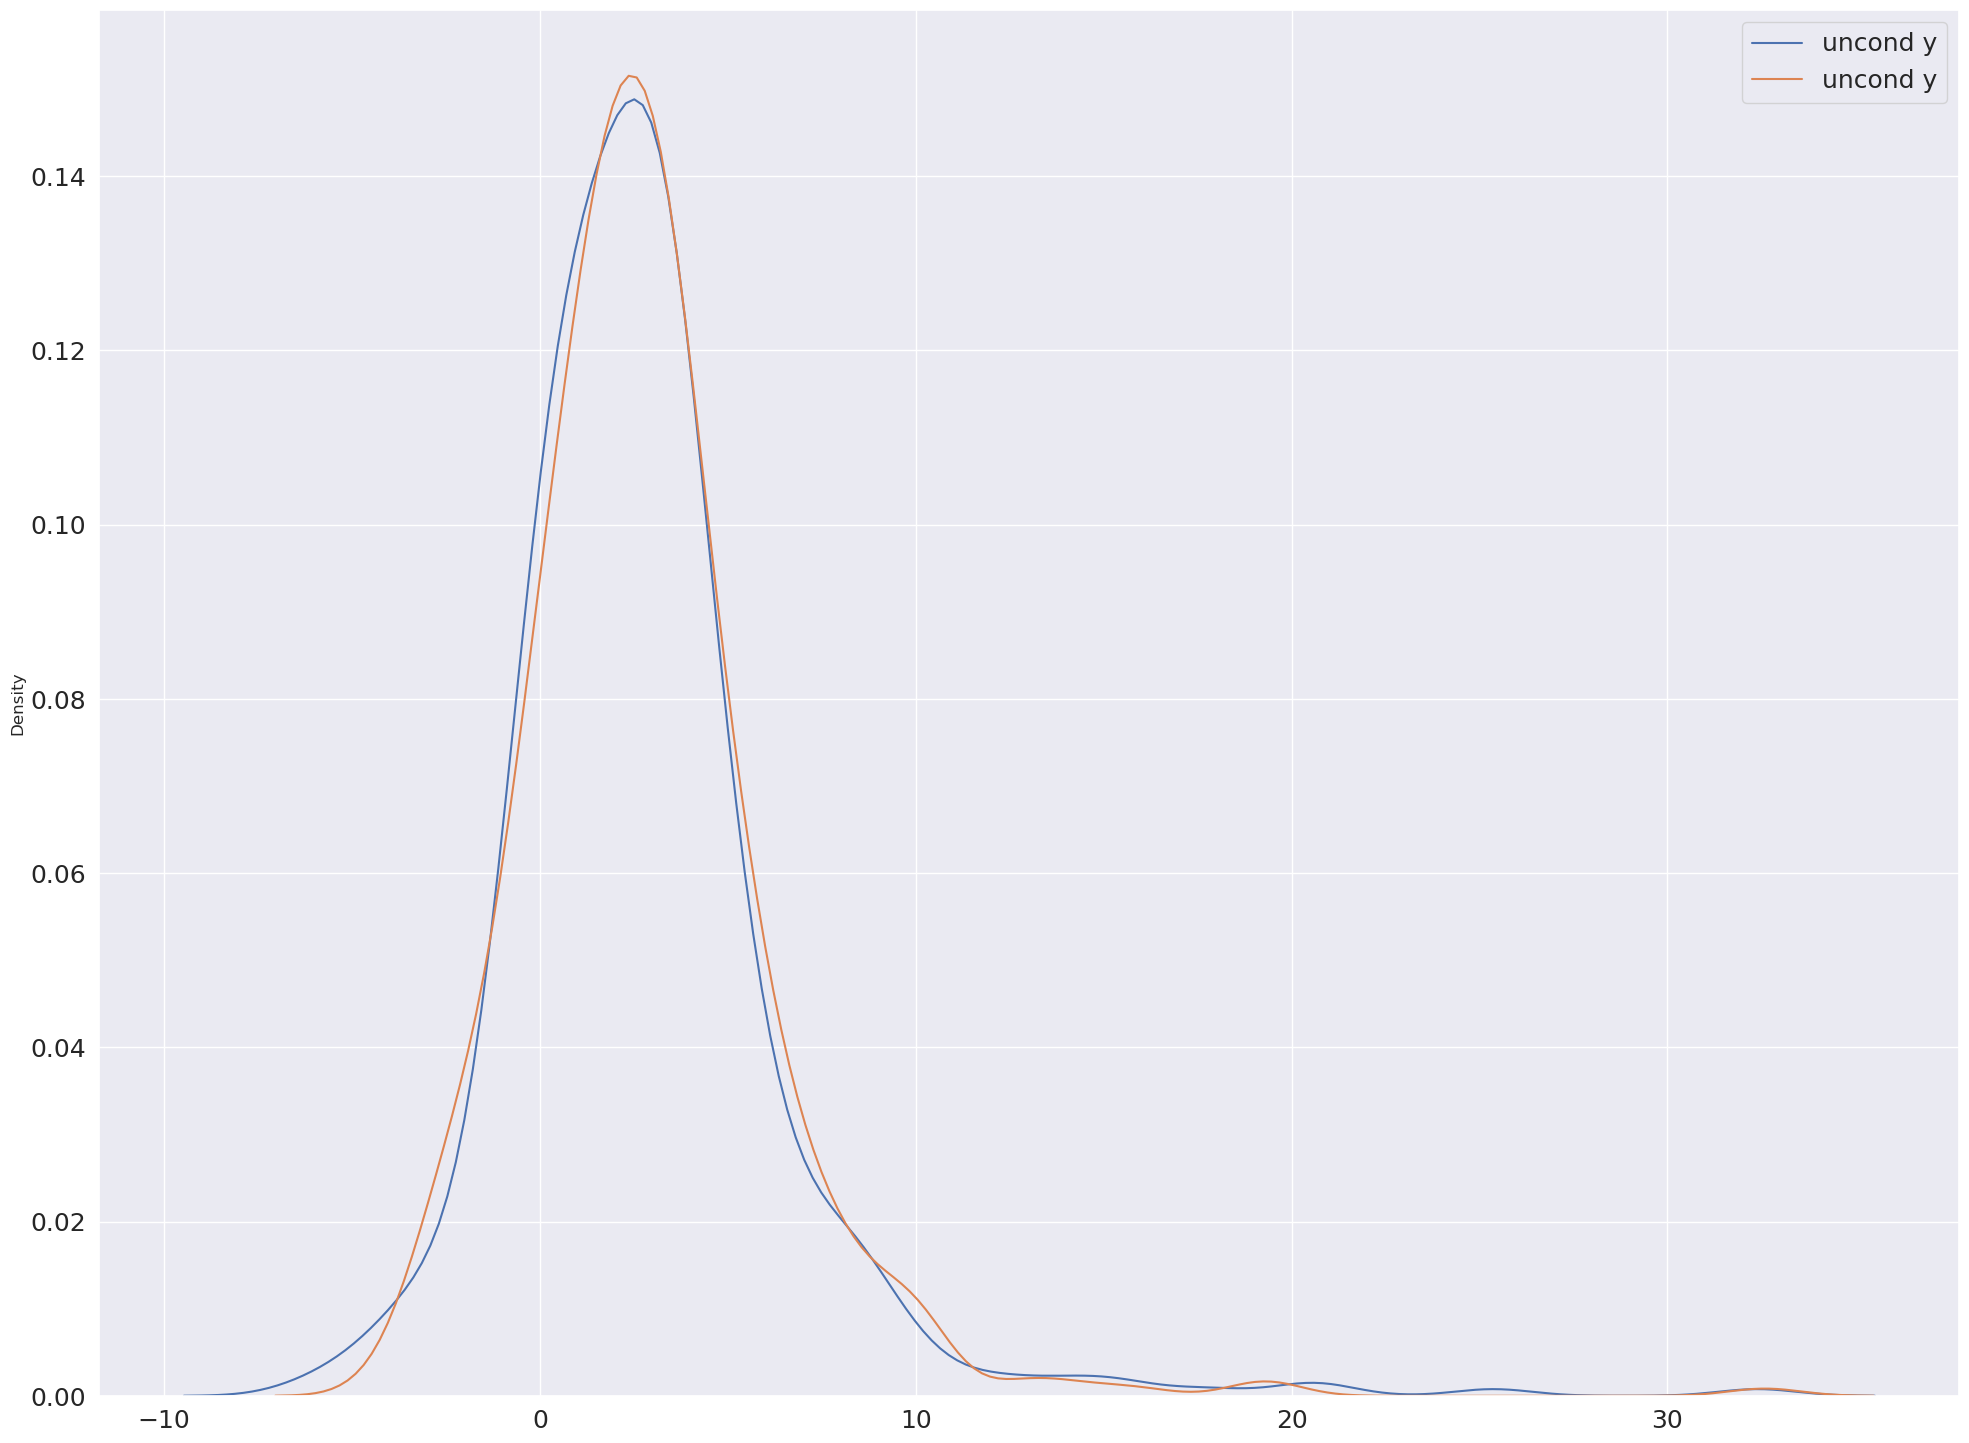

In [14]:
sns.kdeplot(dataset_y.view(-1).detach().cpu().numpy(), label = 'uncond y')
sns.kdeplot(y_gen.view(-1).detach().cpu().numpy(), label = 'uncond y')

plt.legend()

In [15]:
num_test = 500
z_fix=torch.ones(num_test,dz)*torch.normal(0,1,(dz,))
z_fix=z_fix.to(device)
y_fix=z_fix[:,0:1]**2+torch.exp(z_fix[:,1:2]+
                                z_fix[:,2:3]/3)+z_fix[:,3:4]-z_fix[:,4:5]+(0.5+z_fix[:,1:2]**2/2+z_fix[:,4:5]**2/2)*torch.randn((num_test,1)).to(device)

In [16]:
y_fix=y_fix.to(device)
z_fix_normalized = (z_fix - x_min) / (x_max - x_min) +0.01
z_fix_normalized_transformed = transform(z_fix_normalized/1.02).float().to(device)

y_seq = sample_from_diff(model, num_samples=x_normalized_transformed.shape[0], 
                                input_dim=y_fix.shape[1],
                                cond=torch.tensor(z_fix_normalized_transformed).to(device).float(),
                                alphas_bar_sqrt=alphas_bar_sqrt,
                                one_minus_alphas_bar_sqrt=one_minus_alphas_bar_sqrt,
                                betas=betas,
                                num_steps=num_steps,
                                device=device)


/tmp/ipykernel_2096190/2147617884.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cond=torch.tensor(z_fix_normalized_transformed).to(device).float(),


In [17]:
y_sorted = inverse_to_original(y_seq[-1],y_min,y_max).view(-1).sort().values

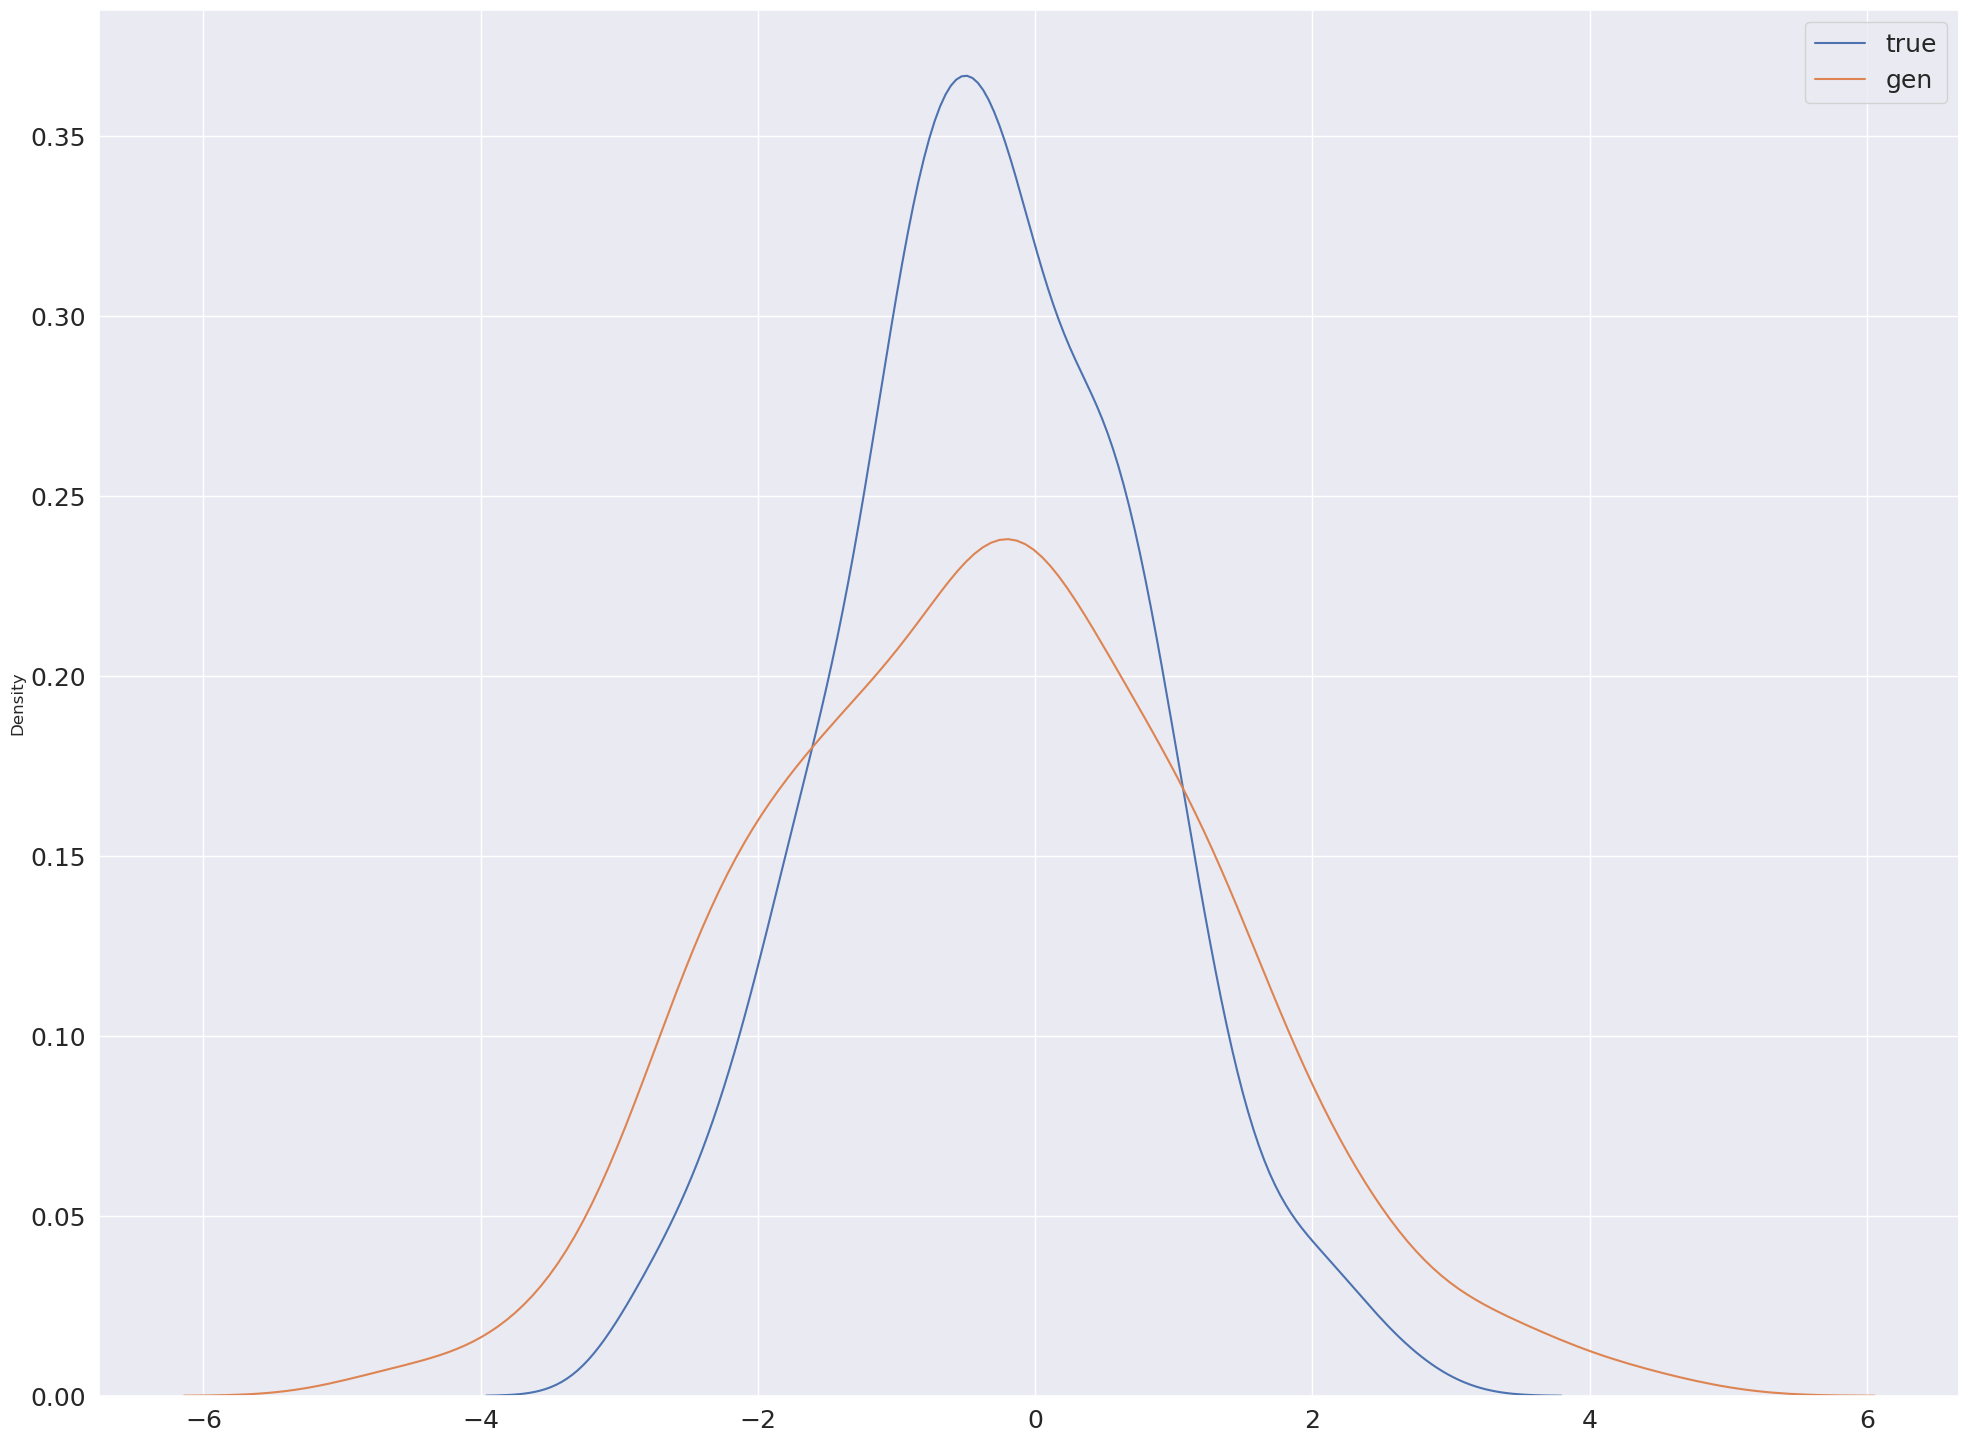

In [18]:
sns.kdeplot(y_fix.view(-1).detach().cpu().numpy(), label = 'true')
sns.kdeplot(y_sorted.view(-1).detach().cpu().numpy(), label = 'gen')
plt.legend()

In [19]:
quantile_005=0.05
quantile_025=0.25
quantile_050=0.50
quantile_075=0.75
quantile_095=0.95
result=[]
repeat=100
num_test=500
for i in range(repeat):
    seed_everything(i+51)
    print(i)
    z_fix=torch.ones(num_test,dz)*torch.normal(0,1,(dz,))
    z_fix=z_fix.to(device)
    y_fix=z_fix[:,0:1]**2+torch.exp(z_fix[:,1:2]+
                                    z_fix[:,2:3]/3)+z_fix[:,3:4]-z_fix[:,4:5]+(0.5+z_fix[:,1:2]**2/2+z_fix[:,4:5]**2/2)*torch.randn((num_test,1)).to(device)
    y_fix=y_fix.to(device)
    z_fix_normalized = (z_fix - x_min) / (x_max - x_min) +0.01
    z_fix_normalized_transformed = transform(z_fix_normalized/1.02).float().to(device)

    y_seq = sample_from_diff(model, num_samples=x_normalized_transformed.shape[0], 
                                    input_dim=y_fix.shape[1],
                                    cond=torch.tensor(z_fix_normalized_transformed).to(device).float(),
                                    alphas_bar_sqrt=alphas_bar_sqrt,
                                    one_minus_alphas_bar_sqrt=one_minus_alphas_bar_sqrt,
                                    betas=betas,
                                    num_steps=num_steps,
                                    device=device)
    y_sorted = inverse_to_original(y_seq[-1],y_min,y_max).view(-1).sort().values
    #MSE of quantile
    x_sorted=(y_fix).view(-1).sort().values
    mse_005=(y_sorted[round(num_test*quantile_005)]-x_sorted[round(num_test*quantile_005)])**2
    mse_025=(y_sorted[round(num_test*quantile_025)]-x_sorted[round(num_test*quantile_025)])**2
    mse_050=(y_sorted[round(num_test*quantile_050)]-x_sorted[round(num_test*quantile_050)])**2
    mse_075=(y_sorted[round(num_test*quantile_075)]-x_sorted[round(num_test*quantile_075)])**2
    mse_095=(y_sorted[round(num_test*quantile_095)]-x_sorted[round(num_test*quantile_095)])**2
    result.append((mse_005.detach(),mse_025.detach(),mse_050.detach(),mse_075.detach(),mse_095.detach(),mse_005.detach()+mse_025.detach()+mse_050.detach()+mse_075.detach()+mse_095.detach()))
    print(result[-1][-1])

    
quantile_005_mse=0
quantile_025_mse=0
quantile_050_mse=0
quantile_075_mse=0
quantile_095_mse=0
quantile_total=0
for i in result:
    quantile_005_mse+=i[0]
    quantile_025_mse+=i[1]
    quantile_050_mse+=i[2]
    quantile_075_mse+=i[3]
    quantile_095_mse+=i[4]
    quantile_total+=i[5]
    
print(f'result:{quantile_005_mse/repeat,quantile_025_mse/repeat,quantile_050_mse/repeat,quantile_075_mse/repeat,quantile_095_mse/repeat,quantile_total/repeat}')

0


/tmp/ipykernel_2096190/2815438994.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cond=torch.tensor(z_fix_normalized_transformed).to(device).float(),


tensor(1.6492, device='cuda:0')
1
tensor(3.2954, device='cuda:0')
2
tensor(3.7791, device='cuda:0')
3
tensor(9.5016, device='cuda:0')
4
tensor(2.0657, device='cuda:0')
5
tensor(5.2705, device='cuda:0')
6
tensor(4.0181, device='cuda:0')
7
tensor(4.0694, device='cuda:0')
8
tensor(4.2148, device='cuda:0')
9
tensor(9.0039, device='cuda:0')
10
tensor(4.0203, device='cuda:0')
11
tensor(0.8536, device='cuda:0')
12
tensor(3.1760, device='cuda:0')
13
tensor(1.5669, device='cuda:0')
14
tensor(2.3784, device='cuda:0')
15
tensor(8.0380, device='cuda:0')
16
tensor(2.7648, device='cuda:0')
17
tensor(20.9466, device='cuda:0')
18
tensor(7.7559, device='cuda:0')
19
tensor(5.8525, device='cuda:0')
20
tensor(3.9364, device='cuda:0')
21
tensor(14.3261, device='cuda:0')
22
tensor(3.4581, device='cuda:0')
23
tensor(7.5066, device='cuda:0')
24
tensor(4.2385, device='cuda:0')
25
tensor(1.2007, device='cuda:0')
26
tensor(3.9755, device='cuda:0')
27
tensor(0.1052, device='cuda:0')
28
tensor(2.0485, device='cuda

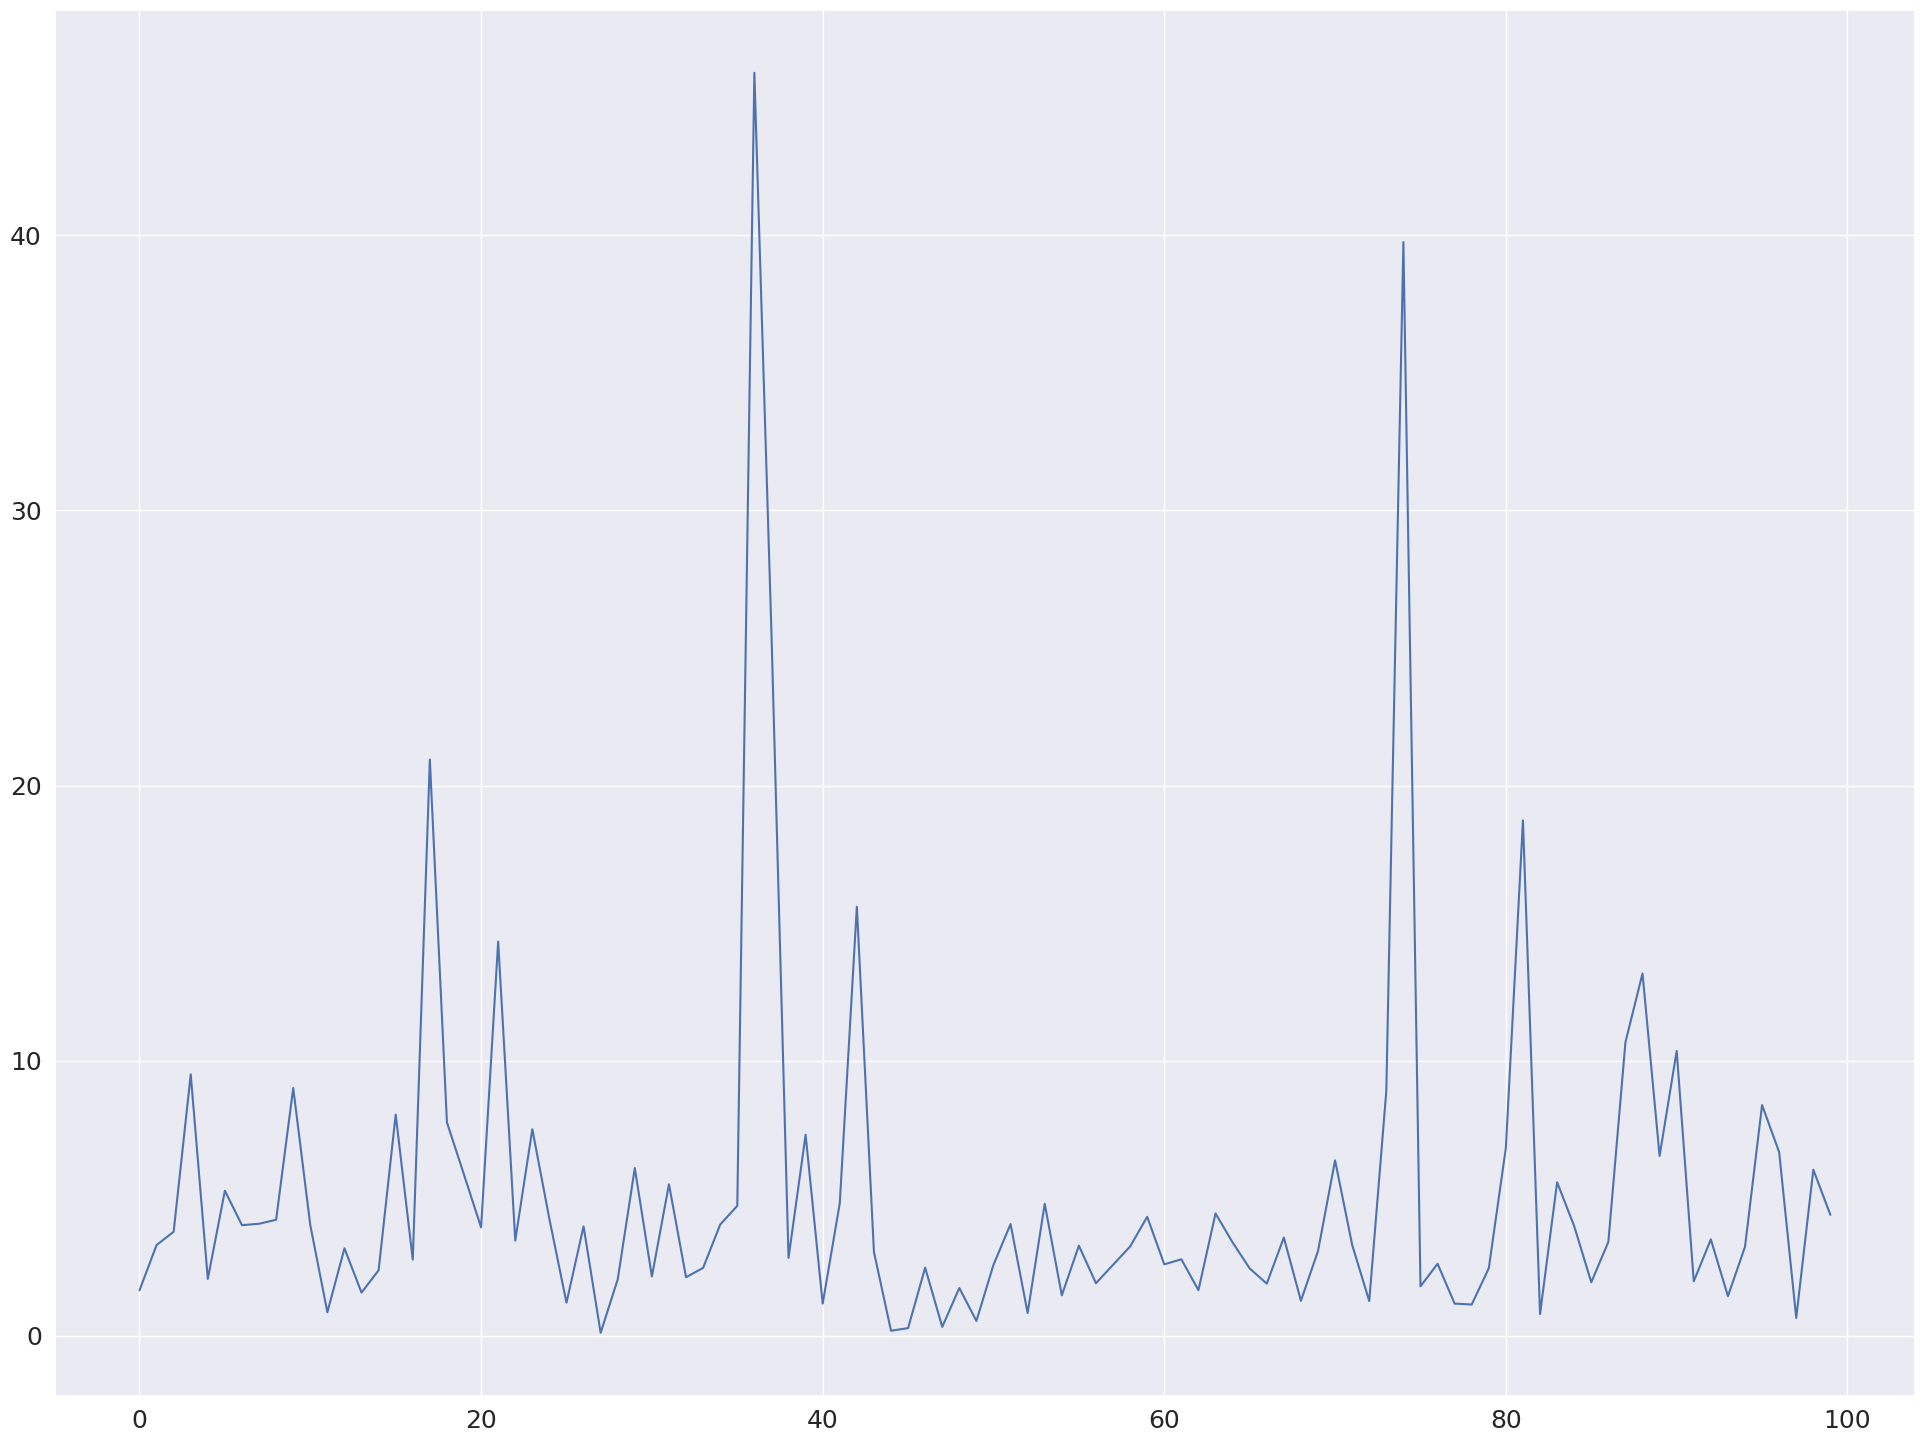

In [20]:
total_loss_list=[]
for i in result:
    total_loss_list.append(i[-1].detach().cpu())
plt.plot(total_loss_list)

In [21]:
result_std=torch.zeros((5,100))
for i in range(len(result)):
    result_std[0,i]=result[i][0].item()
    result_std[1,i]=result[i][1].item()
    result_std[2,i]=result[i][2].item()
    result_std[3,i]=result[i][3].item()
    result_std[4,i]=result[i][4].item()


In [22]:
result_std.std(dim=1)

tensor([3.2450, 1.0227, 0.7610, 0.9388, 2.7463])